<a href="https://colab.research.google.com/github/Lawrencium-103/Britz/blob/main/Cattle_Detection_Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
# CNN DEPENDENCIES
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [7]:
!pip install opendatasets


In [8]:
import opendatasets as od


In [9]:
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oladejilawrence
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:16<00:00, 38.2MB/s]


In [10]:
# Specifying Images and Labels

images = []
labels = []
# Specify the libraries first
cow_images = r"/content/animals10/raw-img/mucca"  # Cows
noncow_images = r"/content/animals10/raw-img/pecora" #  Sheep




In [43]:
import os
from PIL import Image

# Specifying Images and Labels
images = []
labels = []

# Specify the directories for images
cow_images_dir = r"/content/animals10/raw-img/mucca"  # Cows
noncow_images_dir = r"/content/animals10/raw-img/pecora"  # Sheep

# Function to load images and labels
def load_images_from_directory(directory, label):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check for image file extensions
            img_path = os.path.join(directory, filename)
            try:
                img = Image.open(img_path)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Load cow images
load_images_from_directory(cow_images_dir, label='cow')

# Load non-cow (sheep) images
load_images_from_directory(noncow_images_dir, label='sheep')

# Assess data summary
num_cow_images = labels.count('cow')
num_sheep_images = labels.count('sheep')
total_images = len(images)

# Print the summary
print("Data Summary:")
print(f"Total images: {total_images}")
print(f"Cow images: {num_cow_images}")
print(f"Sheep images: {num_sheep_images}")


Data Summary:
Total images: 3686
Cow images: 1866
Sheep images: 1820


In [11]:
# Loading images

for image in os.listdir(cow_images):
    img = cv2.imread(os.path.join(cow_images, image))
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(1) # cow


for image in os.listdir(noncow_images):
    img = cv2.imread(os.path.join(noncow_images, image))
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(0) # sheep

In [12]:
# Converting to arrays
images = np.array(images)
labels = np.array(labels)
# images = images.astype('float32') / 255.0

In [13]:
images.shape

(3686, 224, 224, 3)

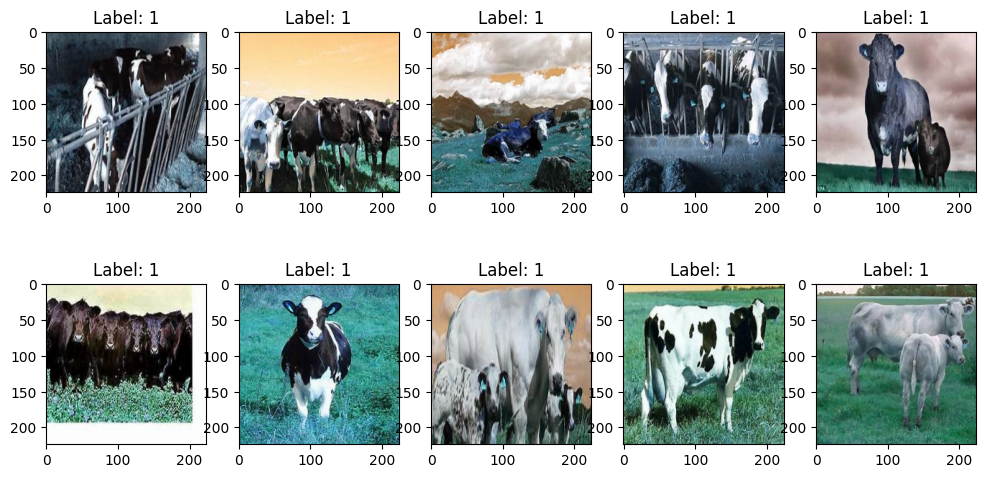

In [14]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')

In [15]:
# Spplitting the dataset to get the train and test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [16]:
print('The Training set: ', X_train.shape)
print('The Testing Features set: ', X_test.shape)
print('The Training Target set: ', y_train.shape)
print('The Testing Target set: ', y_test.shape)

The Training set:  (2948, 224, 224, 3)
The Testing Features set:  (738, 224, 224, 3)
The Training Target set:  (2948,)
The Testing Target set:  (738,)


In [17]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(32, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(16, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(8, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),

    #Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    #BatchNormalization(),
    #Dropout(0.5),


    # Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(1, activation='sigmoid')
])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,313 (48.10 KB)

 Trainable params: 12,169 (47.54 KB)

 Non-trainable params: 144 (576.00 B)

In [19]:
cnn_model = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.5515 - loss: 1.0642 - val_accuracy: 0.6111 - val_loss: 0.6486
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.6450 - loss: 0.7388 - val_accuracy: 0.6477 - val_loss: 0.6753
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.6870 - loss: 0.6302 - val_accuracy: 0.6856 - val_loss: 0.6561
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7327 - loss: 0.5688 - val_accuracy: 0.7588 - val_loss: 0.5137
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.7376 - loss: 0.5393 - val_accuracy: 0.8022 - val_loss: 0.4572
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.7508 - loss: 0.5002 - val_accuracy: 0.7398 - val_loss: 0.5077
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.7674 - loss: 0.4944 - val_accuracy: 0.6924 - val_loss: 0.6038
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7780 - loss: 0.4699 - val_accuracy: 0.7981 - v

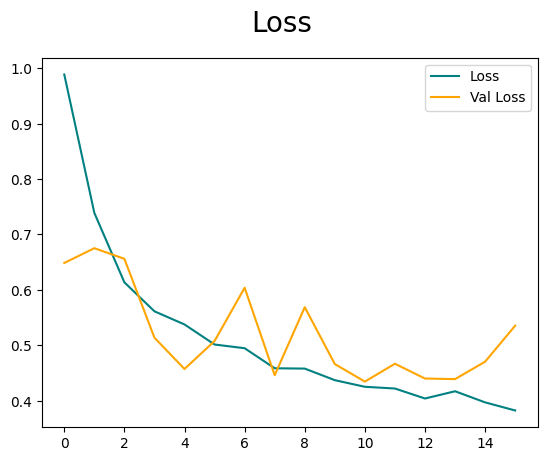

In [20]:
fig = plt.figure()

# Access the `history` attribute to get the loss values
plt.plot(cnn_model.history['loss'], color='teal', label='Loss')
plt.plot(cnn_model.history['val_loss'], color='orange', label='Val Loss')

fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

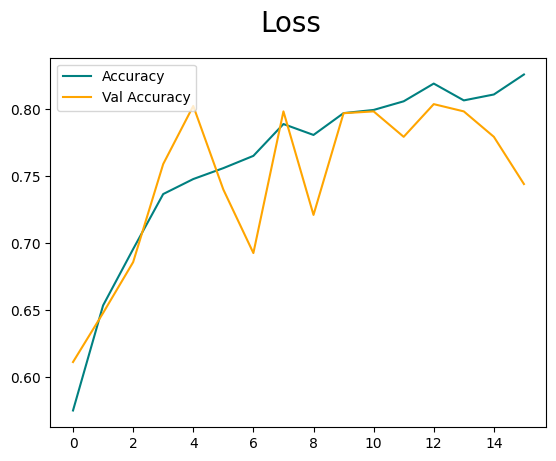

In [21]:
fig = plt.figure()
plt.plot(cnn_model.history['accuracy'], color='teal', label='Accuracy')
plt.plot(cnn_model.history['val_accuracy'], color='orange', label='Val Accuracy')
fig.suptitle('Loss', fontsize= 20)
plt.legend(loc='upper left')
plt.show()

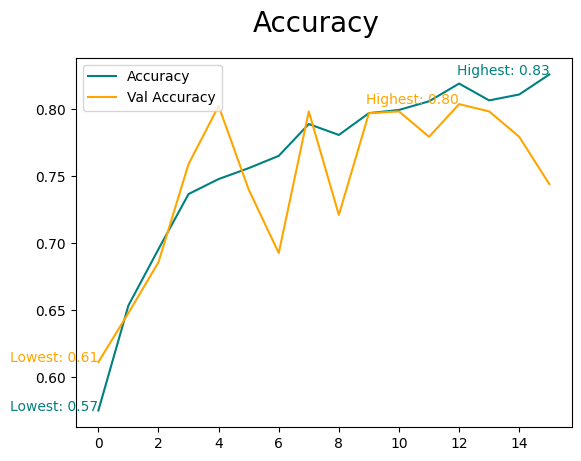

In [42]:
# Create a figure
fig = plt.figure()

# Plot accuracy and validation accuracy
plt.plot(cnn_model.history['accuracy'], color='teal', label='Accuracy')
plt.plot(cnn_model.history['val_accuracy'], color='orange', label='Val Accuracy')

# Set the title and legend
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')

# Annotate highest and lowest points for Accuracy
max_accuracy = max(cnn_model.history['accuracy'])
min_accuracy = min(cnn_model.history['accuracy'])
plt.text(x=cnn_model.history['accuracy'].index(max_accuracy), y=max_accuracy,
         s=f'Highest: {max_accuracy:.2f}', color='teal', fontsize=10, ha='right')
plt.text(x=cnn_model.history['accuracy'].index(min_accuracy), y=min_accuracy,
         s=f'Lowest: {min_accuracy:.2f}', color='teal', fontsize=10, ha='right')

# Annotate highest and lowest points for Validation Accuracy
max_val_accuracy = max(cnn_model.history['val_accuracy'])
min_val_accuracy = min(cnn_model.history['val_accuracy'])
plt.text(x=cnn_model.history['val_accuracy'].index(max_val_accuracy), y=max_val_accuracy,
         s=f'Highest: {max_val_accuracy:.2f}', color='orange', fontsize=10, ha='right')
plt.text(x=cnn_model.history['val_accuracy'].index(min_val_accuracy), y=min_val_accuracy,
         s=f'Lowest: {min_val_accuracy:.2f}', color='orange', fontsize=10, ha='right')

# Show the plot
plt.show()

In [37]:
test_img_path = '/content/e83db30d29f7063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'

In [41]:
# Specify the path to your image
image_path = 'e83db30d29f7063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'

# Load the image
test_img = cv2.imread(image_path)

# Check if the image has been loaded successfully
if test_img is None:
    print(f"Error: Could not load image at {image_path}")
else:
    print("The image has been loaded successfully.")

    # Resize the image if needed (optional)
    test_img = cv2.resize(test_img, (224, 224))

    # Display the image in a window
    cv2.imshow("Image", test_img)

Error: Could not load image at e83db30d29f7063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg


In [40]:
if test_img is None:
    print(f"Error: Could not load image at {test_img_path}")
else:
    print("The image has been loaded successfully.")
    test_img = cv2.resize(test_img, (224, 224))


Error: Could not load image at /content/e83db30d29f7063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg


In [38]:
test_img = cv2.resize(test_img, (224, 224))

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [36]:
# List to hold loaded images
images = []

# Iterate through files in the directory
for file_name in os.listdir(test_img_path):
    # Check for common image file extensions
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Create the full path to the image file
        file_path = os.path.join(test_img_path, file_name)
        # Read and append the image to the list
        img = cv2.imread(file_path)
        if img is not None:
            images.append(img)

# Now 'images' contains all loaded images
print(f"Loaded {len(images)} images from {test_img_path}.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/e83db30d29f7063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'

In [31]:
   test_img = cv2.resize(test_img, (224, 224))

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [26]:
model.predict(np.expand_dims(test_img, axis=0))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type NoneType).

# **Different Architecture**

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(32, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(16, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(8, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),


    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
cnn_a = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
fig = plt.figure()
plt.plot(cnn_a.history['accuracy'], color='teal', label='Accuracy')
plt.plot(model.fit.history['val_accuracy'], color='orange', label='Val Accuracy')
fig.suptitle('Loss', fontsize= 20)
plt.legend(loc='upper left')
plt.show()